In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import torch
import torch.nn as nn
import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *
from torch.optim.lr_scheduler import StepLR

In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.imaging.crosscorr_imaging import Xcorr
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 40, 40, 40
dx, dy, dz = 0.01, 0.01, 0.01
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 5000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
nrperface = 4

# don't need to change below
nxyz = [nx, ny, nz]
dxyz = [dx, dy, dz]
gridded_recs, nr, rec_string = recgeom(nxyz, dxyz, nrperfc_xyz=[nrperface])
print (nr, gridded_recs.shape)

96 (3, 96)


In [5]:
# Microseismic source - SINGULAR
sx, sy, sz = [nx//2, ny//4, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

# MAKE DATA

In [6]:
fs = 100000  # SAMPLING FREQUENCY
fwav = 10000  # WAVELET CENTRAL FREQUENCY
nt = 251  # TIME SAMPLES


In [7]:
fnyq = 0.5 * fs
dt = 1/fs
t = np.arange(nt)*dt
print(max(t))

0.0025


Text(0.5, 1.0, 'Ricker, Fc: 10000 Hz [Fnyq: 50000 Hz]')

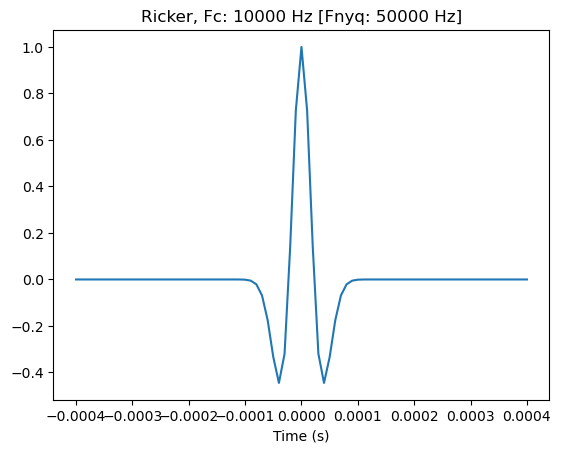

In [8]:
# WAVELET
wav, wavt, wavc = ricker(t[:41], f0=fwav)
plt.plot(wavt, wav,)
plt.xlabel('Time (s)')
plt.title('Ricker, Fc: %i Hz [Fnyq: %i Hz]'%(fwav,fnyq))

In [9]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-2685.4690936227803 - u^H(Op^Hv)=-2685.469093622759


Text(0.5, 1.0, 'Point Receivers')

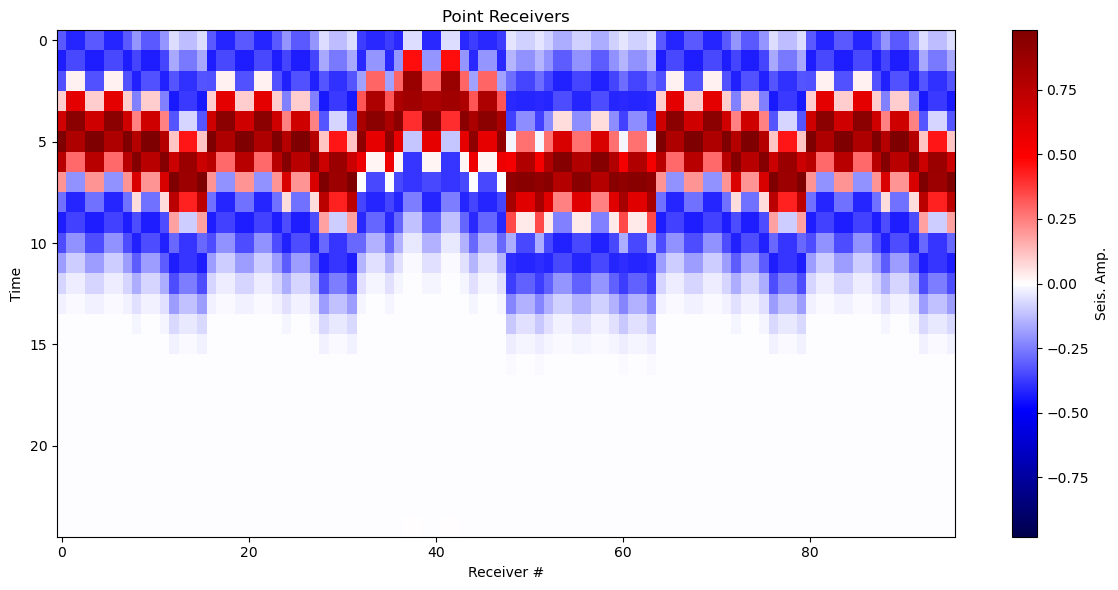

In [10]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata[:,:25], climQ=99.99)
ax.set_title('Point Receivers')

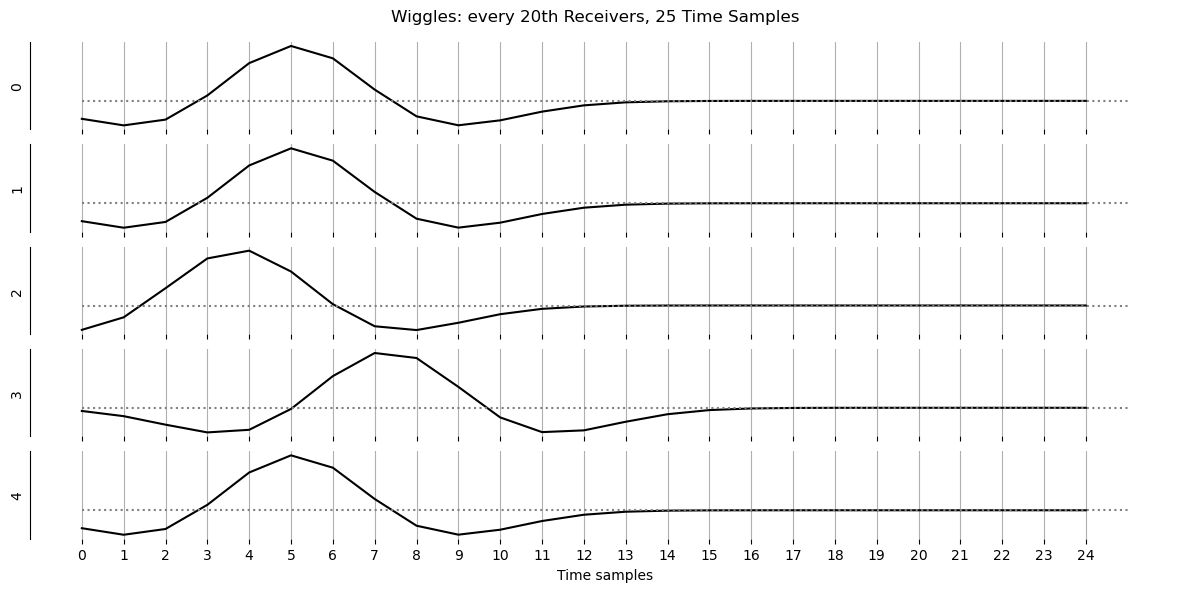

In [11]:
fig, axs = wiggleplot(frwddata[::20,:25], norm_indiv=True, figsize=[12, 6]);
fig.suptitle('Wiggles: every 20th Receivers, 25 Time Samples')
fig.tight_layout()

# POINT REC MIGRATION

True Hypo Center: [20, 10, 20]
Migration-Based Hypo Center: [20.  10.5 20. ]
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 24096 rows and 64000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.614e+01  1.614e+01    1.0e+00  9.2e+01
     1 -8.38849e-06   8.659e+00  8.659e+00    5.4e-01  5.2e-01   1.8e+03  1.0e+00
     2 -3.27856e-05   5.439e+00  5.439e+00    3.4e-01  3.0e-01   2.2e+03  2.3e+00
     3 -5.73941e-05   3.566e+00  3.566e+00    2.2e-01  2.1e-01   2.4e+03  4.0e+00
     4 -4.75297e-05   2.459e+00  2.459e+00    1.5e-01  7.1e-02   2.6e+03  5.9e+00
     5  9.48494e-05   1.574e+00  1.574e+00    9.8e-02  1.4e-01   2.6e+03  1.3e+01
     6  1.07988e-04   1.470e+00  1.470e+00    9.1e-02  9.6e-02   2.8e+03  1.5e+01
     7  1.26045e-04   1.288e+00  1.28

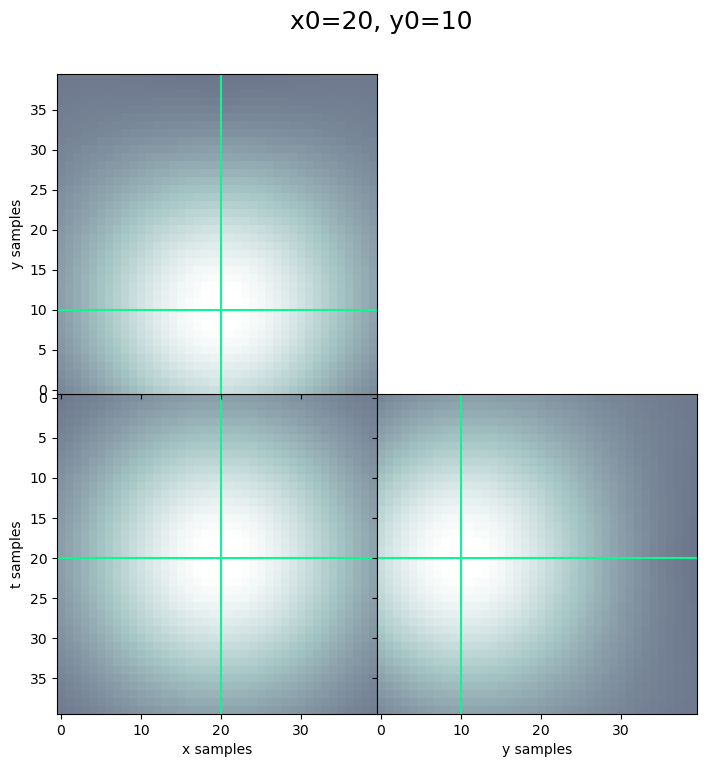

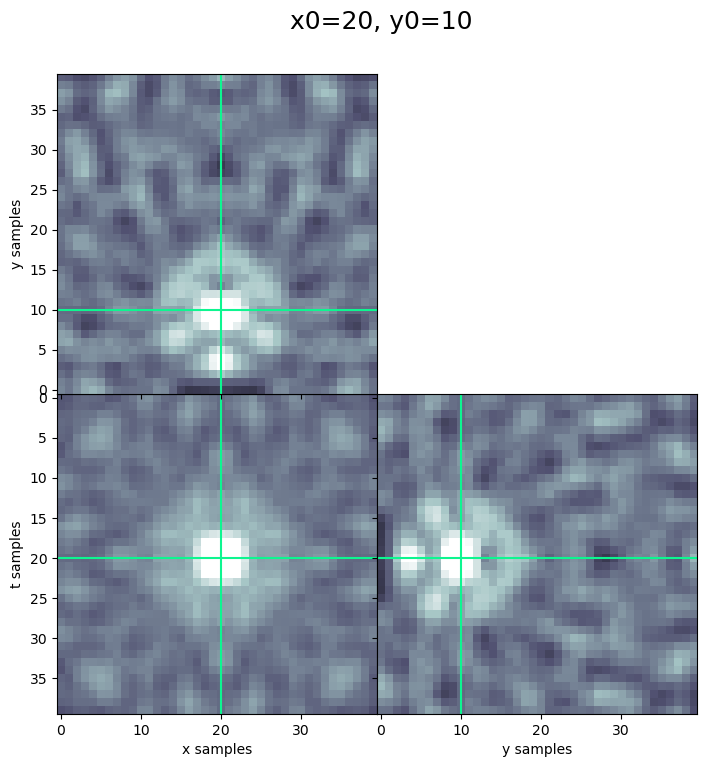

In [12]:
print('True Hypo Center:', [sx,sy,sz])

migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx,sy)

inv = (lsqr(Op, frwddata.ravel(), iter_lim=100, show=True)[0]).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(inv, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)

Text(0.5, 1.0, 'Point Receivers')

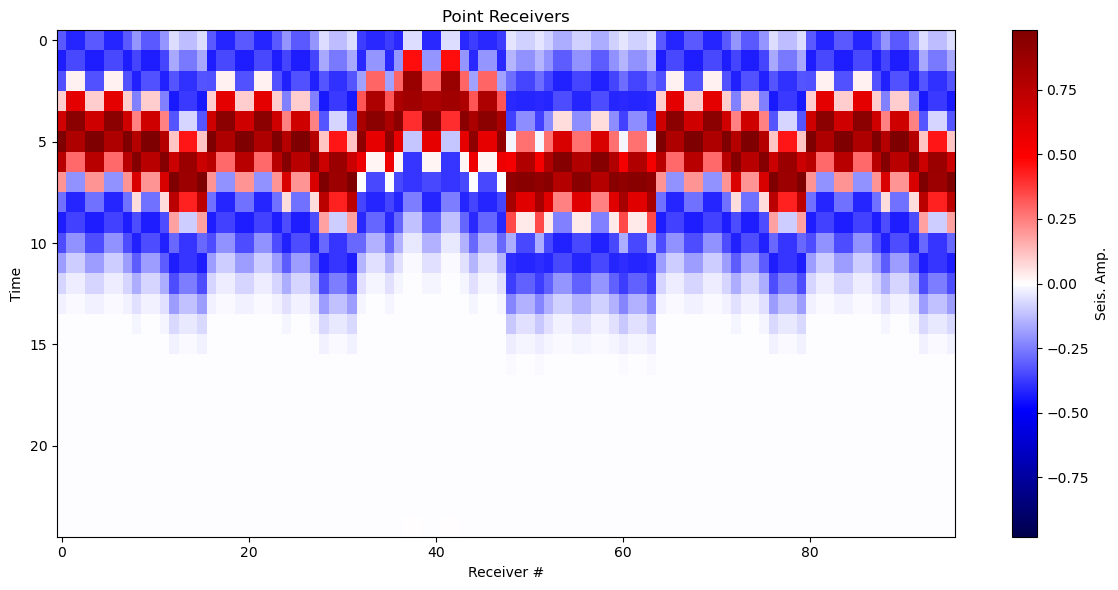

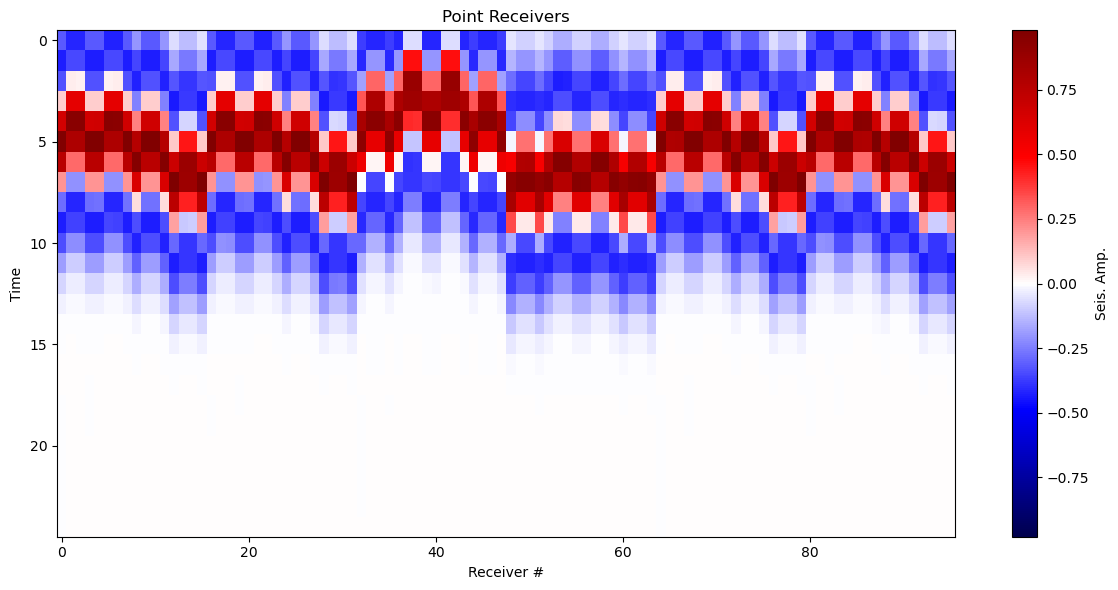

In [13]:
invdata = (Op @ inv.ravel()).reshape(frwddata.shape)

fig,ax = traceimage(frwddata[:,:25], climQ=99.99)
ax.set_title('Point Receivers')

fig,ax = traceimage(invdata[:,:25], climQ=99.99)
ax.set_title('Point Receivers')

## Torch LS

In [14]:
m = torch.zeros(nx*ny*nz)
m.requires_grad = True # make sure we compute the gradient with respect to x

dobs = torch.from_numpy(frwddata.copy().ravel())
TOp = pylops.TorchOperator(Op)

# Optimization
optimizer = torch.optim.SGD([m], lr=1e-3)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
niter = 200
losshist = np.zeros(niter)
for i in range(niter):
    optimizer.zero_grad()
    d = TOp(m)
    loss = criterion(d, dobs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losshist[i] = loss.item()
    if i % 10 == 0:
        print(f'Iteration {i}, Loss: {loss.item():.5f}')

dls_torch = d.detach().cpu().numpy().reshape(frwddata.shape)
mls_torch = m.detach().cpu().numpy().reshape(nx, ny, nx)

Iteration 0, Loss: 0.01081
Iteration 10, Loss: 0.00173
Iteration 20, Loss: 0.00093
Iteration 30, Loss: 0.00063
Iteration 40, Loss: 0.00047
Iteration 50, Loss: 0.00038
Iteration 60, Loss: 0.00035
Iteration 70, Loss: 0.00032
Iteration 80, Loss: 0.00030
Iteration 90, Loss: 0.00028
Iteration 100, Loss: 0.00027
Iteration 110, Loss: 0.00026
Iteration 120, Loss: 0.00026
Iteration 130, Loss: 0.00025
Iteration 140, Loss: 0.00025
Iteration 150, Loss: 0.00024
Iteration 160, Loss: 0.00024
Iteration 170, Loss: 0.00024
Iteration 180, Loss: 0.00023
Iteration 190, Loss: 0.00023


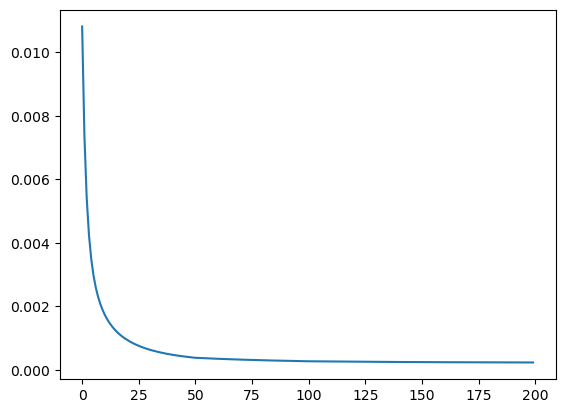

In [15]:
plt.plot(losshist)

LSQR Computed Hypo Center: [20.   9.5 20. ]


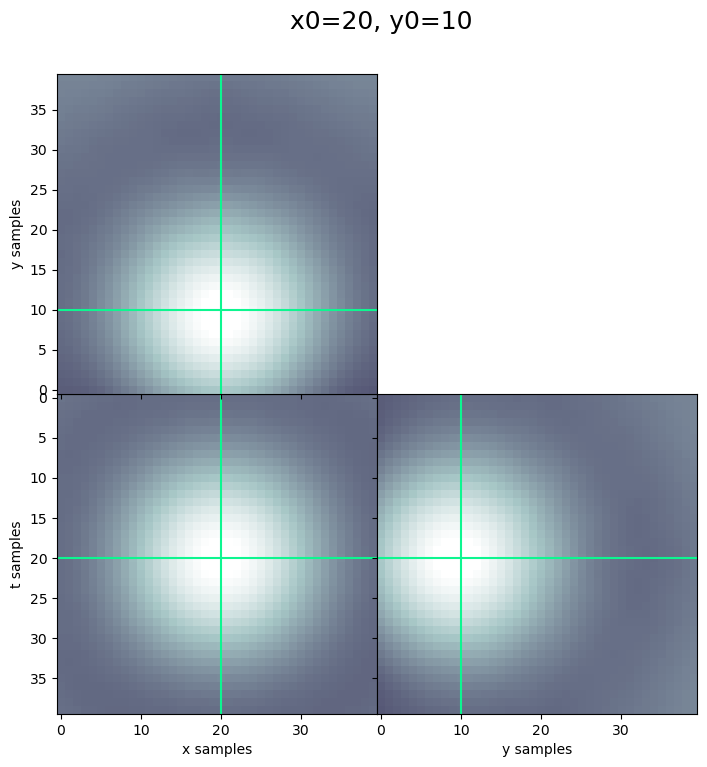

In [16]:
hc, hcs =  get_max_locs(mls_torch, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(mls_torch,sx,sy)

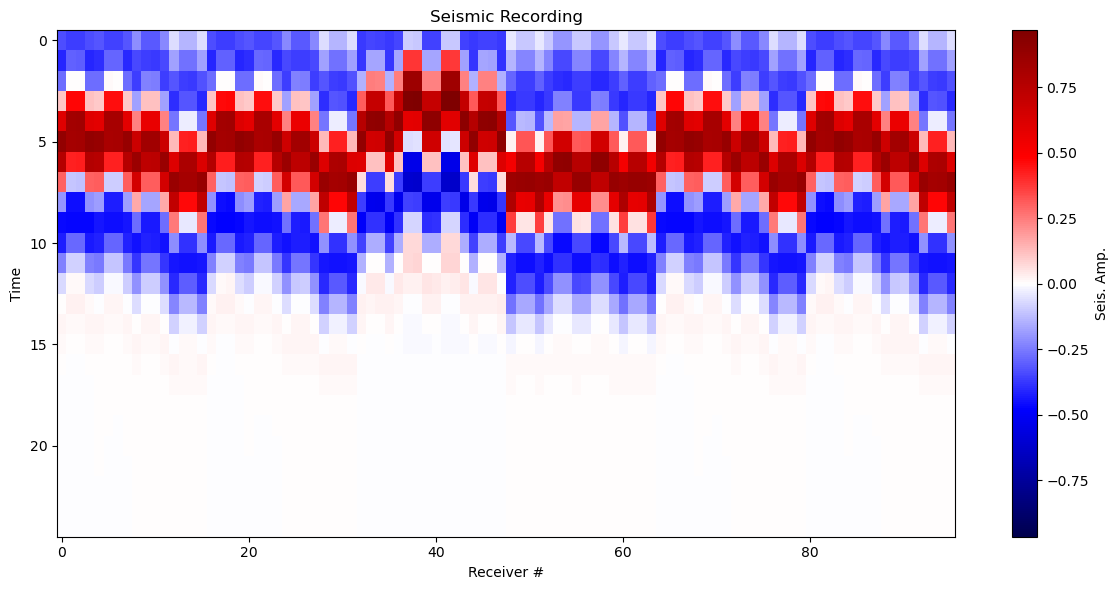

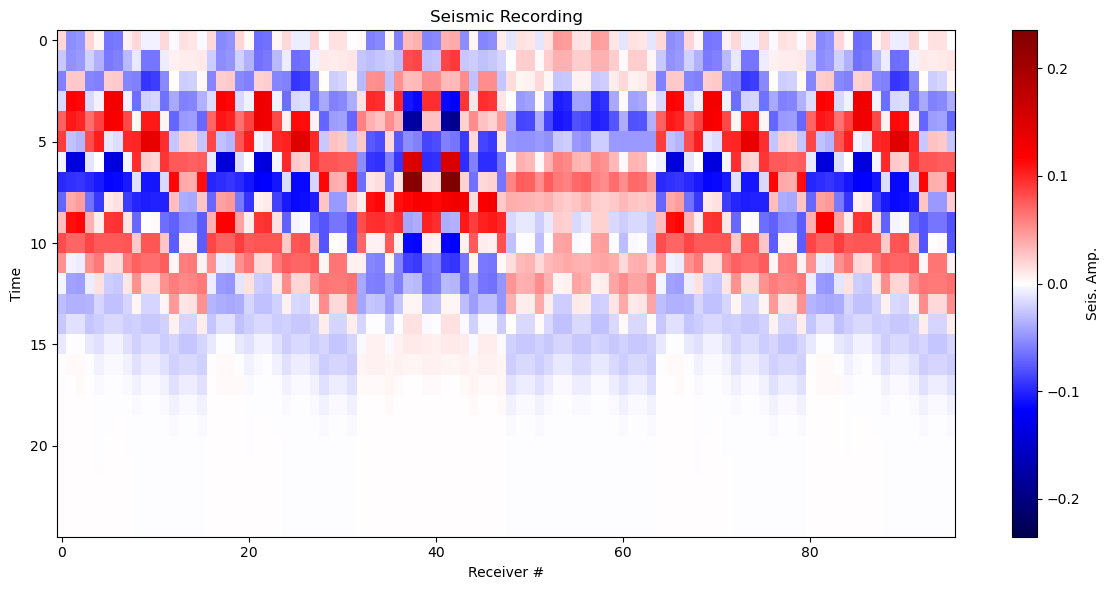

In [17]:
dls_torch = d.detach().cpu().numpy().reshape(frwddata.shape)

fig,ax = traceimage(dls_torch[:,:25], climQ=99.99)
fig,ax = traceimage((frwddata-dls_torch)[:,:25], climQ=99.99)

## Torch Xcorr

In [43]:
dmigrated = Op @ migrated.ravel()
scaling = frwddata.max() / dmigrated.max() 
scaling

4.0473452539412147e-07

In [80]:
m = torch.from_numpy(migrated.copy().ravel() * scaling)
m.requires_grad = True # make sure we compute the gradient with respect to x

dobs = torch.from_numpy(frwddata.copy().ravel())
# print(dobs.min().item(), dobs.max().item())
TOp = pylops.TorchOperator(Op)

# Optimization
optimizer = torch.optim.SGD([m], lr=1e-5)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
niter = 500
eps = 8e-1

losshist = np.zeros(niter)
for i in range(niter):
    optimizer.zero_grad()
    d = TOp(m)
    # print(d.min().item(), d.max().item(), dobs.min().item(), dobs.max().item())
    
    # data term
    lossd = Xcorr(d, dobs)
    # L1 reg
    reg = torch.sum(torch.abs(m))
    # total loss
    loss = lossd + eps * reg
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    losshist[i] = loss.item()
    if i % 10 == 0:
        print(f'Iteration {i}, Loss: {loss.item():.5f}')

dls_torch = d.detach().cpu().numpy().reshape(frwddata.shape)
mls_torch = m.detach().cpu().numpy().reshape(nx, ny, nx)

Iteration 0, Loss: 0.64831
Iteration 10, Loss: -0.12944
Iteration 20, Loss: -0.57522
Iteration 30, Loss: -0.53180
Iteration 40, Loss: -0.55224
Iteration 50, Loss: -0.82519
Iteration 60, Loss: -0.74424
Iteration 70, Loss: -0.88798
Iteration 80, Loss: -0.87316
Iteration 90, Loss: -0.91341
Iteration 100, Loss: -0.90394
Iteration 110, Loss: -0.93732
Iteration 120, Loss: -0.94117
Iteration 130, Loss: -0.94597
Iteration 140, Loss: -0.94781
Iteration 150, Loss: -0.95011
Iteration 160, Loss: -0.95100
Iteration 170, Loss: -0.95213
Iteration 180, Loss: -0.95257
Iteration 190, Loss: -0.95312
Iteration 200, Loss: -0.95334
Iteration 210, Loss: -0.95361
Iteration 220, Loss: -0.95372
Iteration 230, Loss: -0.95386
Iteration 240, Loss: -0.95391
Iteration 250, Loss: -0.95398
Iteration 260, Loss: -0.95400
Iteration 270, Loss: -0.95404
Iteration 280, Loss: -0.95405
Iteration 290, Loss: -0.95407
Iteration 300, Loss: -0.95407
Iteration 310, Loss: -0.95408
Iteration 320, Loss: -0.95409
Iteration 330, Loss: -

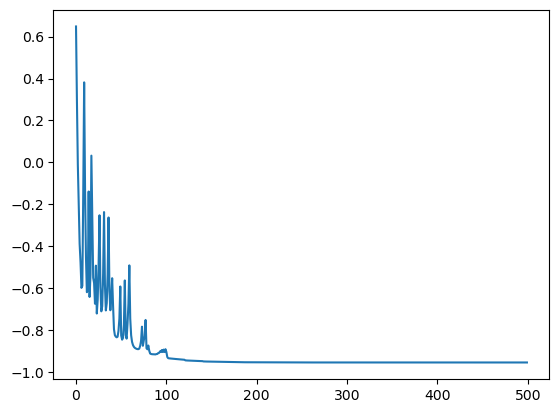

In [86]:
plt.plot(losshist)

LSQR Computed Hypo Center: [19.9 10.3 20. ]


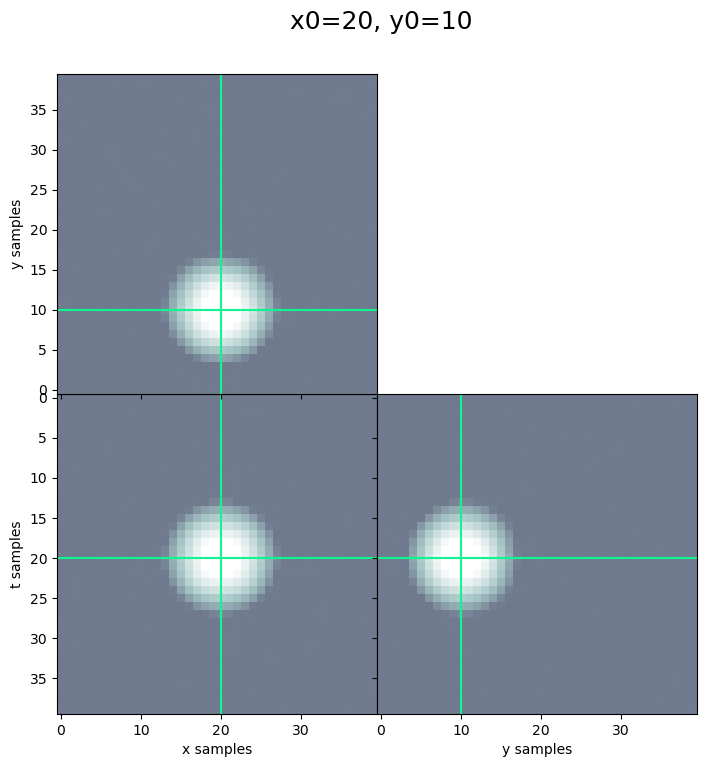

In [87]:
hc, hcs =  get_max_locs(mls_torch, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(mls_torch,sx,sy)

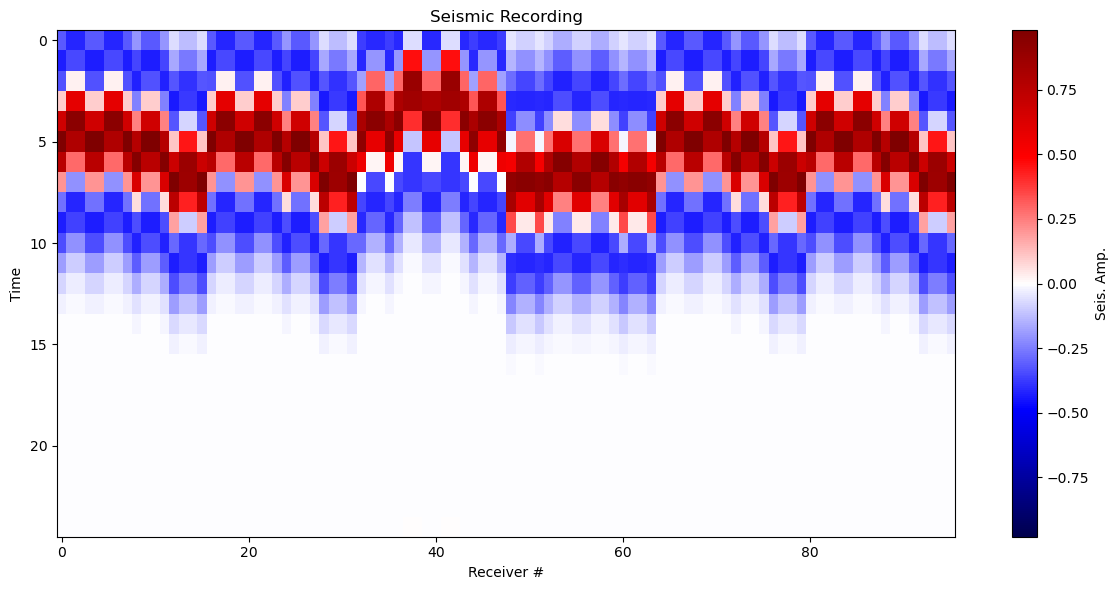

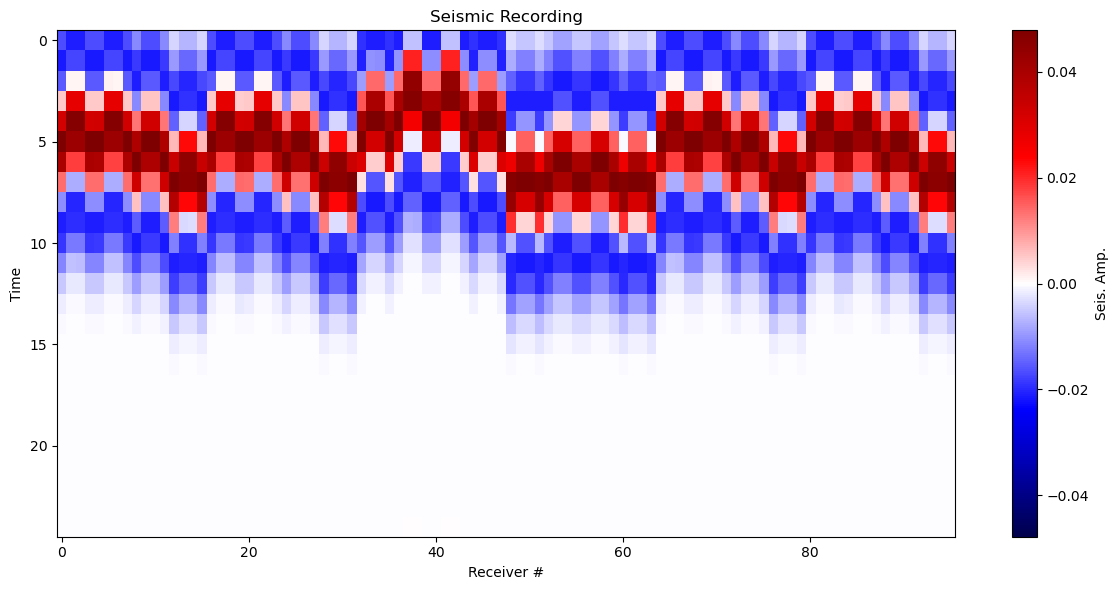

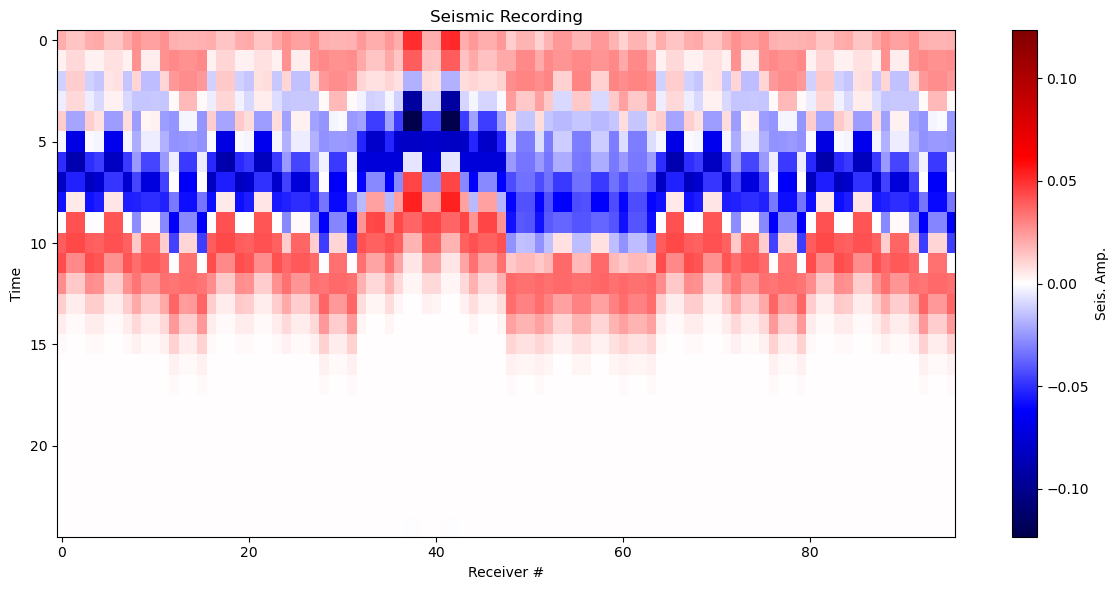

In [90]:
dls_torch = d.detach().cpu().numpy().reshape(frwddata.shape)

fig,ax = traceimage(frwddata[:,:25], climQ=99.99)
fig,ax = traceimage(dls_torch[:,:25], climQ=99.99)

fig,ax = traceimage(frwddata[:,:25] - dls_torch[:,:25] * (frwddata[:,:25].max() / dls_torch[:,:25].max()), climQ=99.99)

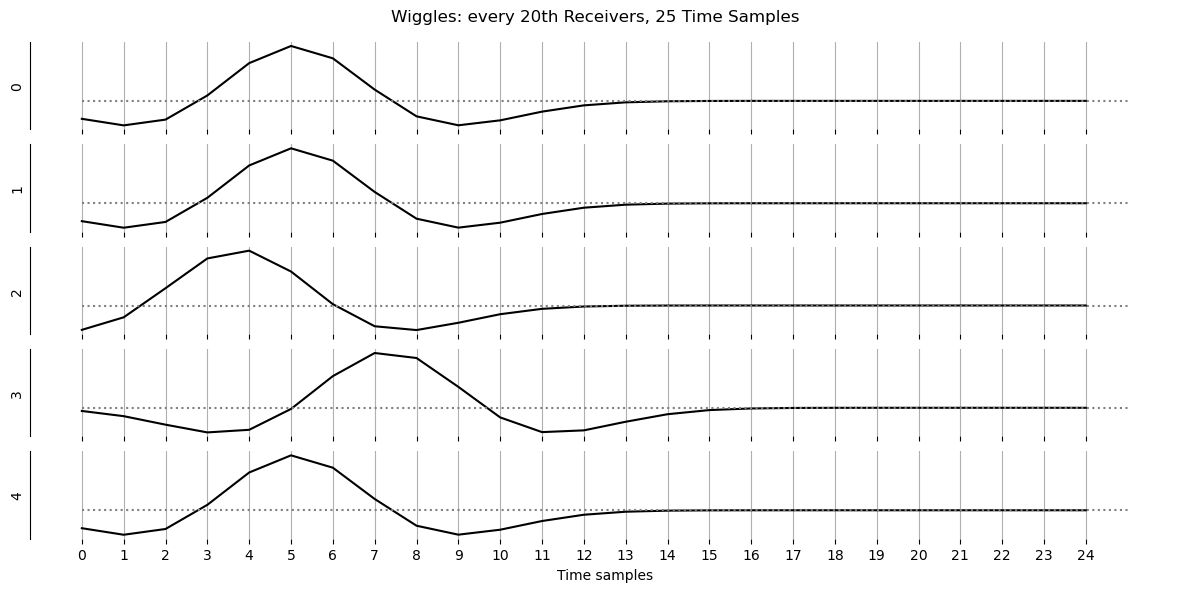

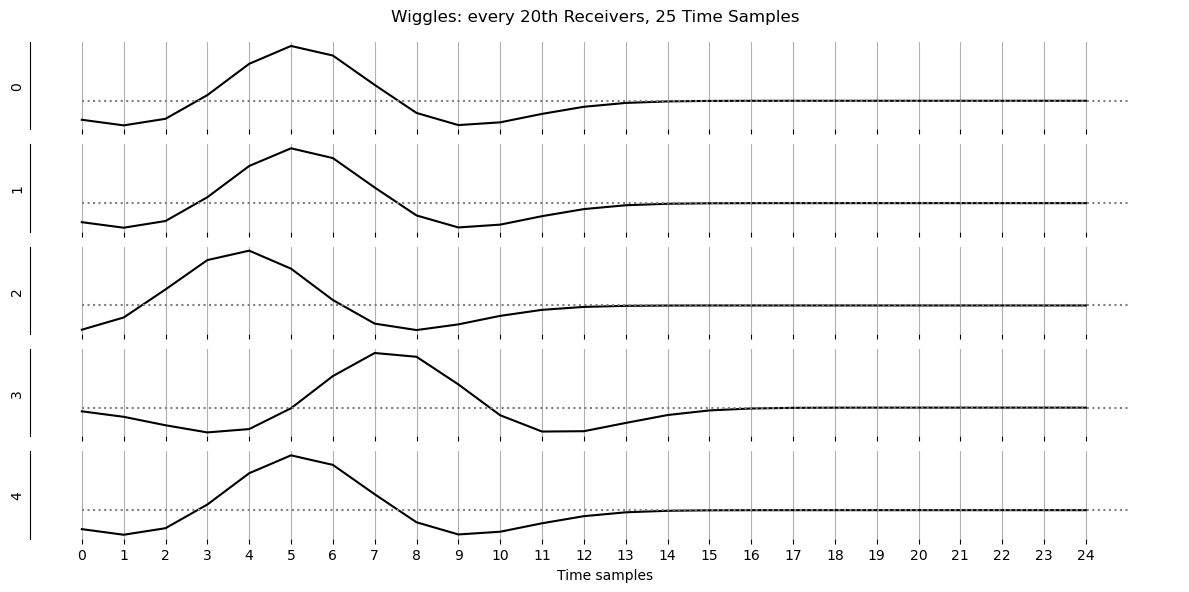

In [89]:
fig, axs = wiggleplot(frwddata[::20,:25], norm_indiv=True, figsize=[12, 6]);
fig.suptitle('Wiggles: every 20th Receivers, 25 Time Samples')
fig.tight_layout()

fig, axs = wiggleplot(dls_torch[::20,:25], norm_indiv=True, figsize=[12, 6]);
fig.suptitle('Wiggles: every 20th Receivers, 25 Time Samples')
fig.tight_layout()